In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
from neuron import PyramidalCells
from sklearn.decomposition import PCA
from itertools import product
import pickle
from tqdm import tqdm

In [2]:

def get_firing_rates(pyramidal, event_count, x_run):

    print('Event count shape:', event_count.shape)
    firing_rates = np.zeros((event_count.shape[1], 1024))
    x_run_reshaped = np.zeros(1024)
    step_size = len(event_count)//firing_rates.shape[1]
    
    for i in range(firing_rates.shape[1]):
        firing_rates[:, i] = np.sum(event_count[i * step_size:(i + 1) * step_size, :], axis = 0) / (step_size*pyramidal.dt)
        x_run_reshaped[i] = np.mean(x_run[i * step_size:(i + 1) * step_size])

    return firing_rates, x_run_reshaped


def get_activation_map(firing_rates, m_EC, x_run_reshaped, n_bins = 64):
    sort_TD = np.argsort(m_EC)
    sorted_fr = firing_rates[np.ix_(sort_TD, np.arange(firing_rates.shape[1]))]

    bins = np.arange(n_bins)
    n_cell = np.arange(sorted_fr.shape[0])
    out_collector = {k : [] for k in product(n_cell, bins)}
    out = np.zeros((sorted_fr.shape[0], n_bins))
    position_bins = np.linspace(0, x_run_reshaped.max(), n_bins)

    for idx, pos in enumerate(x_run_reshaped):
        bin_idx = np.argmin(np.abs(position_bins - pos))

        for i in range(sorted_fr.shape[0]):
            out_collector[(i, bin_idx)].append(sorted_fr[i, idx])

    for k, v in out_collector.items():
        out[k] = np.mean(v)

    return out

def simulate_run(len_track = 200, av_running_speed = 20, dt = 0.01, tn = 1000):
    ## TODO: Does it need to be this long?
    bins = np.arange(0., len_track)
    fps = 1/dt
    n_runs = int(2*tn/(len_track/av_running_speed))

    x = np.array([])
    i = 0
    while True:
        stopping_time = np.random.uniform(0, 1, 2)
        stop1 = np.ones((int(stopping_time[0]*fps),)) * 0.
        speed = av_running_speed + np.random.randn() * 5
        run_length = len(bins) * fps / speed
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time[1]*fps),)) * (len(bins)-1.)
        speed = av_running_speed + np.random.randn() * 5
        run_length = len(bins) * fps / speed
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
        if len(x) >= tn*fps:
            break
        i += 1

    x = x[:int(tn*fps)]
    t = np.arange(len(x))/fps

    return t, x


def smooth(x, window_len=11, window='hanning'):
    """
    Smooth the data using a window with requested size.
    
    Inputs:
        x: Input signal 
        window_len: Dimension of the smoothing window; should be an odd integer
        window: Window type from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    Outputs:
       y: Smoothed signal
    """

    if window_len<3:
        return x

    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]

    if window=='flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y


def intrinsic_dimensionality(points, nstep=10, metric='euclidean', dist_mat=None, ds=1,\
                              plot=1, verbose=0, offset_min=10, win_smooth=7, fit='std',\
                              thr_start=10, thr_fi=1e5):
    '''
    Obtain the intrinsic dimensionality of a point cloud / neural population activity
    by using exponent (slope on log-log plot) ofcumulative neighbours (NN) distrubution
    to estimate intrinsic dimensionality

    Inputs:
         points: NxT point cloud
         n_step: n of distance step to evaluate
         metric: which metric to use to obtain the distance matrix
         dist_mat: if 'precomputed', consider `points` as a distance matrix
         ds: downsampling factor
         plot: visualise curve (boolean)
         verbose: print feedback on code progression
         fit: how to estimate dimewnsionality
           - 'std': use `thr_start` and `thr_fi` to select NN range where to fit exponential
           - 'all': use the full NN range
           - 'diff': find the linear part of the curve (using 2nd diff) and fit line to it
                       (start at offset min at least; `win_smooth` is smoothing parameter to estimate
                        min and max of the 2nd diff)
                        
     Outputs:
         Nneigh: number of neighbours found per point at every radii
         radii: radii steps used
         p: linear fit in log-log axes
         
    Faster than using KD tree
    '''

    from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
    
    Nneigh = np.zeros((points.shape[0],nstep))
    if dist_mat=='precomputed':
        dist_mat = points
    else: # compute distance matrix
        # Find diameter of point cloud
        points[np.isnan(points)] = 0
        if metric=='euclidean': dist_mat = euclidean_distances(points)
        elif metric=='cosine': dist_mat = cosine_distances(points)
    dist_mat[dist_mat==0] = np.nan
    minD = np.nanmin(dist_mat)
    maxD = np.nanmax(dist_mat)
    
    # Define distances to evaluate
    radii = np.logspace(np.log10(minD), np.log10(maxD), nstep)
    # Fing #neigh vs dist
    for n,rad in enumerate(radii):
        Nneigh[:,n] = np.sum((dist_mat<rad), 1)
        if verbose: print(f'{n+1}/{len(radii)}')
    
    # find slope of neighbors increase = dimensionality
    sem = np.std(Nneigh,0)
    mean_ = np.mean(Nneigh,0)
    sem_ = np.log10(sem[1:])
    x2p = radii[1:]; y2p = mean_[1:]
    x2p = x2p / np.max(x2p) # normalise the distance radii
    
    # find indeces where curve is linear for fit
    if fit=='std': # fit line from #thr_start NN until #thre_fi NN
        start = np.argmin(np.abs(mean_ - thr_start))
        fi = np.argmin(np.abs(mean_ - thr_fi))
    elif fit=='diff': # find linear part of the curve using 2nd diff
        diff2nd = np.diff(np.diff(smooth(np.log10(y2p), window_len=win_smooth)))
        fi = np.argmin(diff2nd[offset_min:])+offset_min
        start = np.argmax(diff2nd[:fi])
    elif fit=='all': # use all data
        start = 0
        fi = len(mean_)-1
        
    # line fit
    x2fit = x2p[start:fi]
    y2fit = y2p[start:fi]
    p = np.polyfit(np.log10(x2fit), np.log10(y2fit), deg=1)
    
    # plot
    if plot:
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(5, 5))
        plt.plot(x2p, y2p) # og data
        y_mod = 10**p[1] * np.power(x2fit, p[0]) # best fit power law
        plt.plot(x2fit, y_mod, 'r')
        plt.xlabel('Distance')
        plt.ylabel('# neighbours')
        plt.xscale('log')
        plt.yscale('log')
        plt.title('The dimensionality/slope is %.2f'%p[0])
        sns.despine()
        plt.show()
        plt.close()
        
    return Nneigh, radii, p

In [42]:

t_epoch = 1
speed = 20
len_track = 100. 
dt = 0.001
tn = len_track/speed*32
a = 0.3
n_cells = {'pyramidal' : 200, 'inter_a' : 20, 'inter_b' : 20, 'CA3' : 120}
len_track = 100
n_env = 50
a = 0 ## Similarity between maps
lr = 15
n_bins = 100


DIMS = 5
nstep = 30 # TODO: what does this do?

t_run, x_run = simulate_run(len_track=len_track, av_running_speed=speed, dt=dt, tn=tn)
x_pos = np.arange(0, len_track, 1)



In [ ]:

all_n_dims = {}

for a in np.round(np.linspace(0,1,11),1):
    with open(f'plots/measure_representation/all_envs_{a}.pkl', 'rb') as f:
        all_envs_CA3, all_envs_CA1 = pickle.load(f)
    with open(f'plots/measure_representation/all_envs_no_EC_{a}.pkl', 'rb') as f:
        all_envs_CA1_no_EC = pickle.load(f)

    random = np.random.rand(n_env*x_pos.shape[0], n_cells['CA3'])
    n_dims = {'CA3': [], 'CA1': [], 'CA1_no_EC': [], 'random': []}

    for env_idx in tqdm(range(n_env)):

        for area, X in {
            'CA1': all_envs_CA1[:(env_idx+1)*n_bins, :], 
            'CA1_no_EC': all_envs_CA1_no_EC[:(env_idx+1)*n_bins, :],
            'CA3': all_envs_CA3[:(env_idx+1)*x_pos.shape[0], :],
            'random': random[:(env_idx+1)*x_pos.shape[0], :]
            }.items():
            
            pca = PCA(n_components=DIMS)
            x_embd = pca.fit_transform(X)
            x_embd = x_embd / np.max(np.abs(x_embd)) # normalise the values
            AXIS_LIM = np.max(x_embd)
        
            Nneigh, radii, p = intrinsic_dimensionality(x_embd, nstep=nstep, metric='euclidean',
                                                        fit='std', thr_start=10, thr_fi=5e3, plot=False)
            
            n_dims[area].append(p[0])
        
    all_n_dims[a] = n_dims


  0%|          | 0/50 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:559: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/var/folders/rz/2d6162_s2dg4g65tmvdkq7180000gn/T/ipykernel_29623/4183020434.py:23: RuntimeWarning: invalid value encountered in divide
  x_embd = x_embd / np.max(np.abs(x_embd)) # normalise the values
/var/folders/rz/2d6162_s2dg4g65tmvdkq7180000gn/T/ipykernel_29623/3068943562.py:135: RuntimeWarning: All-NaN slice encountered
  minD = np.nanmin(dist_mat)
/var/folders/rz/2d6162_s2dg4g65tmvdkq7180000gn/T/ipykernel_29623/3068943562.py:136: RuntimeWarning: All-NaN slice encountered
  maxD = np.nanmax(dist_mat)
/var/folders/rz/2d6162_s2dg4g65tmvdkq7180000gn/T/ipykernel_29623/3068943562.py:148: RuntimeWarning: divide by zero encountered in log10
  sem_ = np.log10(sem[1:])
  0%|          | 0/50 [00:00<?, ?it/s]


TypeError: expected non-empty vector for x

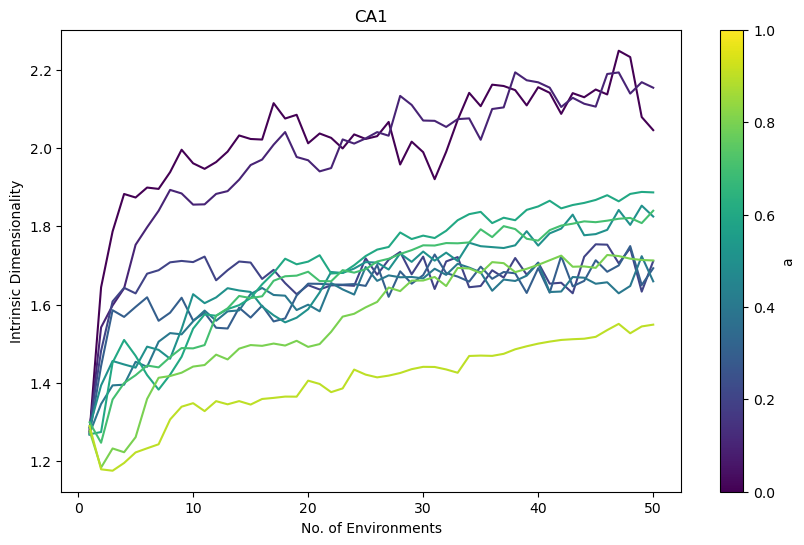

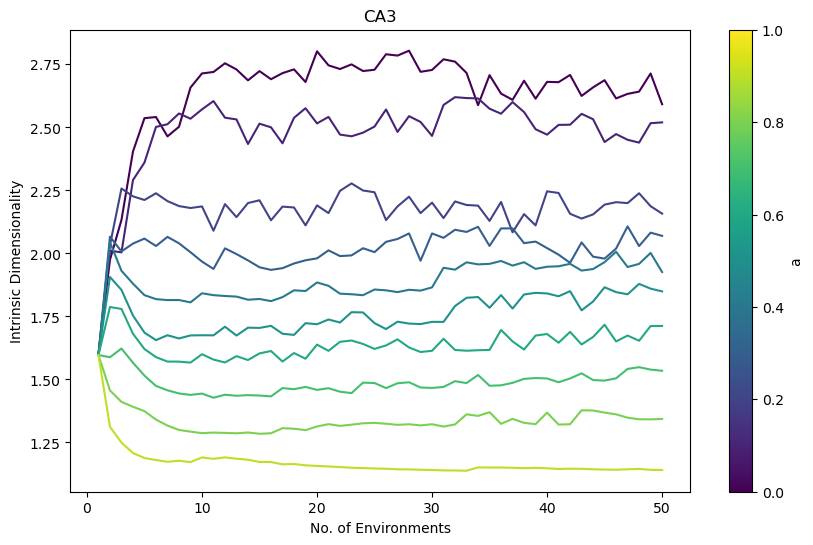

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

for area in ['CA1', 'CA3']:
    fig, ax = plt.subplots(figsize=(10, 6))
    norm = mcolors.Normalize(vmin=min(all_n_dims.keys()), vmax=max(all_n_dims.keys()))
    colormap = cm.viridis
    for a in all_n_dims.keys():
        if a == 1.0:
            continue
        n_dims = all_n_dims[a]
        ax.plot(np.arange(1, len(n_dims[area]) + 1), n_dims[area], color=colormap(norm(a)), label=f'{a:.1f}')
    
    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])  # Dummy array so ScalarMappable is valid
    cbar = fig.colorbar(sm, ax=ax)  # <--- pass ax here!
    cbar.set_label('a')

    ax.set_xlabel('No. of Environments')
    ax.set_ylabel('Intrinsic Dimensionality')
    ax.set_title(area)

    plt.show()
    plt.close()